# Statistical Analysis of Bay Area Bike Share Data

> <b>1</b> Is Commuter ridership affected by Rain?
> 
> <b>2</b> Is Commuter ridership affected by Hot or Cold Temperatures?
>
> <b>3</b> Is Commuter ridership affected by Humidity?

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
# from scipy import stats
# import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

sub_color = 'b'
sub_color_alt = 'm'
cust_color='r'
cust_color_alt='y'

commuter_color='g'
commuter_color_alt='#1daf1d'

commuter_am = '#ea54d9'     #OrRd
commuter_am_alt = '#9b8460' #OrRd_r

commuter_pm = '#b97ccc'     #PuRd
commuter_pm_alt = '#f4ad3a' #PuRd_r

FIG_SIZE = (15,6)
GRID_DIMS = 15

# Load Morning and Evening Commuter Trips Data
## Caltrain Super Station Only

In [3]:
super_station = [69, 70]

In [4]:
print('[%s] Loading Morning Commute Trips Data...' % datetime.datetime.now().time())

morning_commutes = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_morning_commutes.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
    
    chunk = chunk[(chunk.start_station_id.isin(super_station)) |
                  (chunk.end_station_id.isin(super_station))].copy()
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

morning_commutes = pd.concat(chunks)
morning_commutes.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())


print('[%s] Loading Evening Commute Trips Data...' % datetime.datetime.now().time())

evening_commutes = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_evening_commutes.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
    
    chunk = chunk[(chunk.start_station_id.isin(super_station)) |
                  (chunk.end_station_id.isin(super_station))].copy()
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

evening_commutes = pd.concat(chunks)
evening_commutes.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())

[04:25:27.899289] Loading Morning Commute Trips Data...
		[04:25:28.365149] finished chunk 1 of 26
		[04:25:28.804855] finished chunk 3 of 26
		[04:25:29.410424] finished chunk 6 of 26
		[04:25:30.085416] finished chunk 9 of 26
		[04:25:30.713679] finished chunk 12 of 26
		[04:25:31.319348] finished chunk 15 of 26
		[04:25:31.916208] finished chunk 18 of 26
		[04:25:32.599383] finished chunk 21 of 26
		[04:25:33.350272] finished chunk 24 of 26
		[04:25:33.650787] finished chunk 26 of 26
[04:25:33.785707] Complete!
[04:25:33.785927] Loading Evening Commute Trips Data...
		[04:25:34.228537] finished chunk 1 of 24
		[04:25:34.620450] finished chunk 3 of 24
		[04:25:35.224885] finished chunk 6 of 24
		[04:25:35.826579] finished chunk 9 of 24
		[04:25:36.426054] finished chunk 12 of 24
		[04:25:37.033363] finished chunk 15 of 24
		[04:25:37.640081] finished chunk 18 of 24
		[04:25:38.241539] finished chunk 21 of 24
		[04:25:38.804244] finished chunk 24 of 24
[04:25:38.926686] Complete!


# Identify and Tag `Rainy` and `Dry` Commutes
<ul> <b>Rainy Conditions</b> are if any of the following are met at trip start date and time
    <li>Precipitation Intensity is Greater than 0.0</li>
    <li>Precipitation Type is Rain</li>
    <li>Precipitation Probability is Greater than 0.59</li>
</ul>

In [5]:
def tag_rainy_commutes(trip_df=None):
    df = trip_df.copy()
    df['rain_cat'] = 'dry'

    rain_index = df[(df.precipIntensity > 0.0) | 
                                      (df.precipType > 0) | 
                                      (df.precipProbability >= 0.59)].index


    df.iloc[rain_index, list(df.columns).index('rain_cat')] = 'rain'
    
    return df

In [6]:
morning_commutes = tag_rainy_commutes(morning_commutes)
evening_commutes = tag_rainy_commutes(evening_commutes)

# Identify and Tag `Cold`, `Hot` and `Normal` Commutes
<ul>
    <li><b>Cold Conditions</b> are trips starting when the temperature more than one standard deviation below the mean</li>
    <li><b>Hot Conditions</b> are trips starting when the temperature more than one standard deviation above the mean</li>
    <li><b>Normal Conditions</b> are trips starting when the temperature neither `Cold` nor `Hot`</li>
</ul>

In [7]:
def tag_temperature_category(trip_df=None):
    df = trip_df.copy()
    
    hot_cutoff  = df.apparentTemperature.mean() + (1 * df.apparentTemperature.std())
    cold_cutoff = df.apparentTemperature.mean() - (1 * df.apparentTemperature.std())

    df['temp_cat'] = 'Normal'
    hot_index = df[df.apparentTemperature >= hot_cutoff].index
    df.iloc[hot_index,list(df.columns).index('temp_cat')] = 'Hot'

    cold_index = df[df.apparentTemperature <= cold_cutoff].index
    df.iloc[cold_index,list(df.columns).index('temp_cat')] = 'Cold'

    cold_days = df[df.temp_cat == 'Cold'].copy()
    cold_days = len(cold_days.groupby(cold_days.start_date.dt.date).count().index)
    hot_days  = df[df.temp_cat == 'Hot'].copy()
    hot_days = len(hot_days.groupby(hot_days.start_date.dt.date).count().index)
    norm_days = df[df.temp_cat == 'Normal'].copy()
    norm_days = len(norm_days.groupby(norm_days.start_date.dt.date).count().index)

    print('Number of Cold days   {:d}'.format(cold_days))
    print('Number of Hot days    {:d}'.format(hot_days))
    print('Number of Normal days {:d}'.format(norm_days))
    print('')
    print('hot_cutoff    {:3.4f}'.format(hot_cutoff))
    print('cold_cutoff   {:3.4f}'.format(cold_cutoff))
    print('hot trips     {:d}'.format(hot_index.shape[0]))
    print('cold trips    {:d}'.format(cold_index.shape[0]))
    print('normal trips  {:d}'.format(df[df.temp_cat == 'Normal'].shape[0]))
    
    return df

In [8]:
morning_commutes = tag_temperature_category(trip_df=morning_commutes)

Number of Cold days   174
Number of Hot days    179
Number of Normal days 640

hot_cutoff    61.1770
cold_cutoff   51.1148
hot trips     15348
cold trips    12158
normal trips  72352


In [9]:
evening_commutes = tag_temperature_category(trip_df=evening_commutes)

Number of Cold days   212
Number of Hot days    161
Number of Normal days 634

hot_cutoff    68.8091
cold_cutoff   57.1720
hot trips     13276
cold trips    14214
normal trips  72440


# RankSum Test

In [10]:
from scipy.stats import ranksums

In [11]:
def ranksums_test(dfA, dfB, a_label='', b_label=''):
    
    A_mean = dfA.mean()

    B_mean = dfB.mean()

    
    diff_of_means = A_mean - B_mean
    
    # perform ranksums test
    z, p = ranksums(dfA, dfB)
    
    drop_share = diff_of_means / A_mean * 100.
    can_reject = False
    print('{} Intervals   {:d}'.format(a_label, dfA.shape[0]))
    print('{} Intervals   {:d}'.format(b_label , dfB.shape[0]))
    print('{} mean        {:3.5f}'.format(a_label, A_mean))
    print('{} mean        {:3.5f}'.format(b_label, B_mean))
    print('Diff of Means {:3.5f}'.format(diff_of_means))
    print('Share Drop    {:3.5f}'.format(drop_share))
    print('   z stat     {:3.5f}'.format(z))
    print('   p value    {:3.5f}'.format(p))
    
    if p <= 0.05:
        print('Reject the null Hypothesis')
        can_reject = True
    else:
        print('Can not reject the null Hypothesis')
        can_reject = False
        
    results = {'z_score':z, 
               'p_value':p,
               '{} intervals'.format(a_label):dfA.shape[0], 
               '{} intervals'.format(b_label):dfB.shape[0], 
               '{} mean'.format(a_label):A_mean, 
               '{} mean'.format(b_label):B_mean, 
               'diff_of_means':diff_of_means, 
               'drop_share':drop_share,
               'can_reject':can_reject}
    

    return results
    

# Impact of Rain on Commuter Trip Counts


<div class="alert alert-info">

<p><b>1a. Morning Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Rainy Days = Morning Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Rainy Days ≠ Morning Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

In [12]:
chunks = []

for month in sorted(morning_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_trips = morning_commutes[morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    morning_RAINY = month_trips[month_trips['rain_cat'] == 'rain']
    morning_RAINY = morning_RAINY.groupby([morning_RAINY.start_date.dt.date])['trip_id'].count()

    morning_DRY   = month_trips[month_trips['rain_cat'] == 'dry']
    morning_DRY = morning_DRY.groupby([morning_DRY.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(morning_DRY, morning_RAINY, a_label='dry', b_label='wet')
    
    chunks.append(R)
    print('-' * 60)
    
morning_commute_t_test = pd.DataFrame(chunks)
morning_commute_t_test['month'] = month_labels


Month of JAN
dry Intervals   62
wet Intervals   9
dry mean        111.35484
wet mean        58.22222
Diff of Means 53.13262
Share Drop    47.71469
   z stat     3.37873
   p value    0.00073
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
dry Intervals   59
wet Intervals   8
dry mean        120.93220
wet mean        46.50000
Diff of Means 74.43220
Share Drop    61.54870
   z stat     3.57715
   p value    0.00035
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
dry Intervals   62
wet Intervals   8
dry mean        128.22581
wet mean        80.87500
Diff of Means 47.35081
Share Drop    36.92767
   z stat     2.73201
   p value    0.00629
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
dry Intervals   64
wet Intervals   7
dry mean        135.71875
wet mean        43.71429
Diff of Means 92.00446
Share Drop    67.79053
   z stat   

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


dry Intervals   65
wet Intervals   4
dry mean        113.33846
wet mean        29.00000
Diff of Means 84.33846
Share Drop    74.41292
   z stat     2.41370
   p value    0.01579
Reject the null Hypothesis
------------------------------------------------------------

Month of OCT
dry Intervals   69
wet Intervals   2
dry mean        127.14493
wet mean        28.00000
Diff of Means 99.14493
Share Drop    77.97789
   z stat     2.32841
   p value    0.01989
Reject the null Hypothesis
------------------------------------------------------------

Month of NOV
dry Intervals   59
wet Intervals   8
dry mean        113.71186
wet mean        67.37500
Diff of Means 46.33686
Share Drop    40.74937
   z stat     2.32031
   p value    0.02032
Reject the null Hypothesis
------------------------------------------------------------

Month of DEC
dry Intervals   62
wet Intervals   17
dry mean        85.51613
wet mean        43.52941
Diff of Means 41.98672
Share Drop    49.09801
   z stat     2.98836
   p

In [13]:
morning_commute_t_test.fillna(0, inplace=True)
morning_commute_t_test

,can_reject,diff_of_means,drop_share,dry intervals,dry mean,p_value,wet intervals,wet mean,z_score,month
0,True,53.132616,47.714690,62,111.354839,0.000728,9,58.222222,3.378734,JAN
1,True,74.432203,61.548704,59,120.932203,0.000347,8,46.500000,3.577148,FEB
2,True,47.350806,36.927673,62,128.225806,0.006295,8,80.875000,2.732010,MAR
3,True,92.004464,67.790533,64,135.718750,0.000045,7,43.714286,4.079395,APR
4,False,98.430769,71.104690,65,138.430769,0.121496,1,40.000000,1.548526,MAY
5,True,89.276923,61.032814,65,146.276923,0.020278,2,57.000000,2.321160,JUN
6,True,136.227273,97.495120,66,139.727273,0.018307,2,3.500000,2.359351,JUL
7,False,0.000000,0.000000,68,144.750000,0.000000,0,0.000000,0.000000,AUG
8,True,84.338462,74.412922,65,113.338462,0.015792,4,29.000000,2.413697,SEP
9,True,99.144928,77.977887,69,127.144928,0.019890,2,28.000000,2.328411,OCT



<div class="alert alert-info">

<p><b>1b. Evening Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>


<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

In [14]:
chunks = []

for month in sorted(evening_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_trips = evening_commutes[evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    evening_RAINY = month_trips[month_trips['rain_cat'] == 'rain']
    evening_RAINY = evening_RAINY.groupby([evening_RAINY.start_date.dt.date])['trip_id'].count()

    evening_DRY   = month_trips[month_trips['rain_cat'] == 'dry']
    evening_DRY = evening_DRY.groupby([evening_DRY.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(evening_DRY, evening_RAINY, a_label='dry', b_label='wet')
    chunks.append(R)
    print('-' * 60)
    
evening_commute_t_test = pd.DataFrame(chunks)
evening_commute_t_test['month'] = month_labels


Month of JAN
dry Intervals   63
wet Intervals   7
dry mean        116.31746
wet mean        34.28571
Diff of Means 82.03175
Share Drop    70.52402
   z stat     3.83706
   p value    0.00012
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
dry Intervals   58
wet Intervals   6
dry mean        120.32759
wet mean        52.66667
Diff of Means 67.66092
Share Drop    56.23060
   z stat     3.27064
   p value    0.00107
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
dry Intervals   63
wet Intervals   13
dry mean        126.66667
wet mean        60.23077
Diff of Means 66.43590
Share Drop    52.44939
   z stat     4.41421
   p value    0.00001
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
dry Intervals   65
wet Intervals   4
dry mean        133.38462
wet mean        45.50000
Diff of Means 87.88462
Share Drop    65.88812
   z stat  

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


dry Intervals   67
wet Intervals   0
dry mean        138.55224
wet mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of AUG
dry Intervals   67
wet Intervals   0
dry mean        150.08955
wet mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
dry Intervals   65
wet Intervals   0
dry mean        118.41538
wet mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of OCT
dry Intervals   69
wet Intervals   0
dry mean        128.60870
wet mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
---------------

In [15]:
evening_commute_t_test.fillna(0, inplace=True)
evening_commute_t_test

,can_reject,diff_of_means,drop_share,dry intervals,dry mean,p_value,wet intervals,wet mean,z_score,month
0,True,82.031746,70.524017,63,116.317460,0.000125,7,34.285714,3.837057,JAN
1,True,67.660920,56.230597,58,120.327586,0.001073,6,52.666667,3.270639,FEB
2,True,66.435897,52.449393,63,126.666667,0.000010,13,60.230769,4.414213,MAR
3,True,87.884615,65.888120,65,133.384615,0.002061,4,45.500000,3.081316,APR
4,False,56.861538,41.852565,65,135.861538,0.134645,1,79.000000,1.496034,MAY
5,False,105.636364,71.551724,66,147.636364,0.097989,1,42.000000,1.654681,JUN
6,False,0.000000,0.000000,67,138.552239,0.000000,0,0.000000,0.000000,JUL
7,False,0.000000,0.000000,67,150.089552,0.000000,0,0.000000,0.000000,AUG
8,False,0.000000,0.000000,65,118.415385,0.000000,0,0.000000,0.000000,SEP
9,False,0.000000,0.000000,69,128.608696,0.000000,0,0.000000,0.000000,OCT


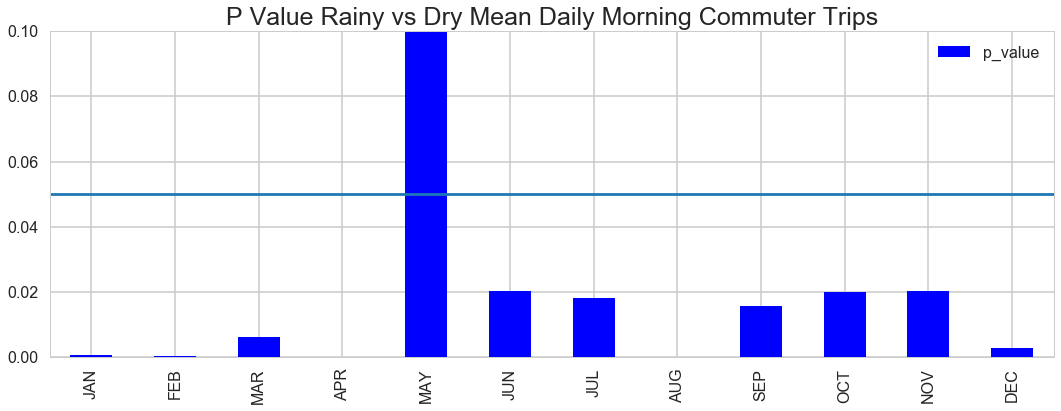

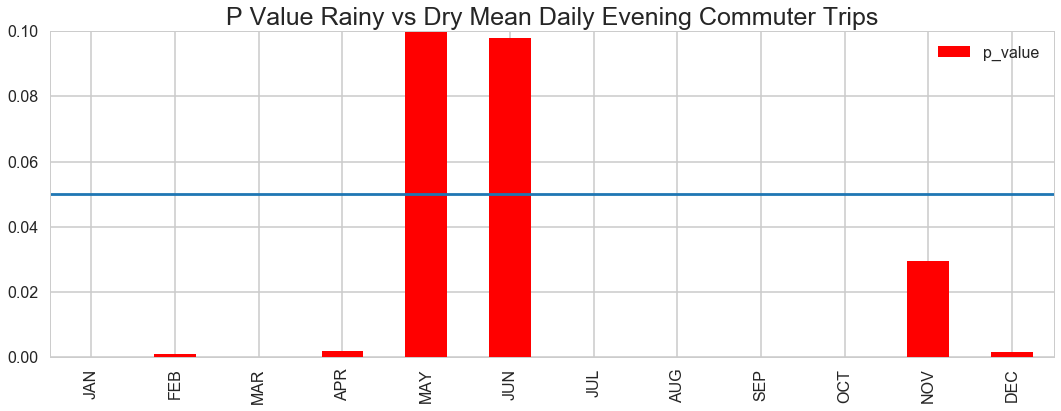

In [16]:
morning_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_commute_t_test.index, month_labels)
# plt.legend(['p-value'], loc=1, frameon=True)
title = 'P Value Rainy vs Dry Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()


evening_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(evening_commute_t_test.index, month_labels)
# plt.legend(['p-value'], loc=1, frameon=True)
title = 'P Value Rainy vs Dry Mean Daily Evening Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()

In [17]:
print('morning drop share {:3.4f}'.format(morning_commute_t_test[['drop_share']].mean()[0]))
print('evening drop share {:3.4f}'.format(evening_commute_t_test[['drop_share']].mean()[0]))

morning drop share 57.1544
evening drop share 38.2799


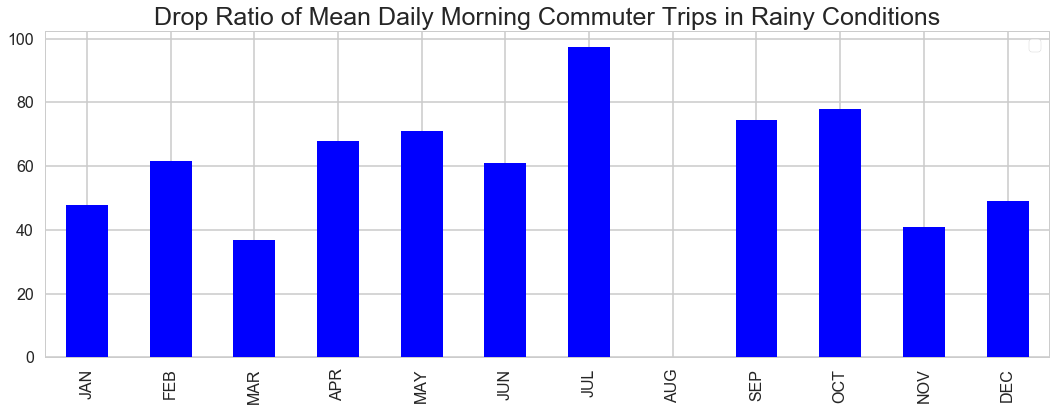

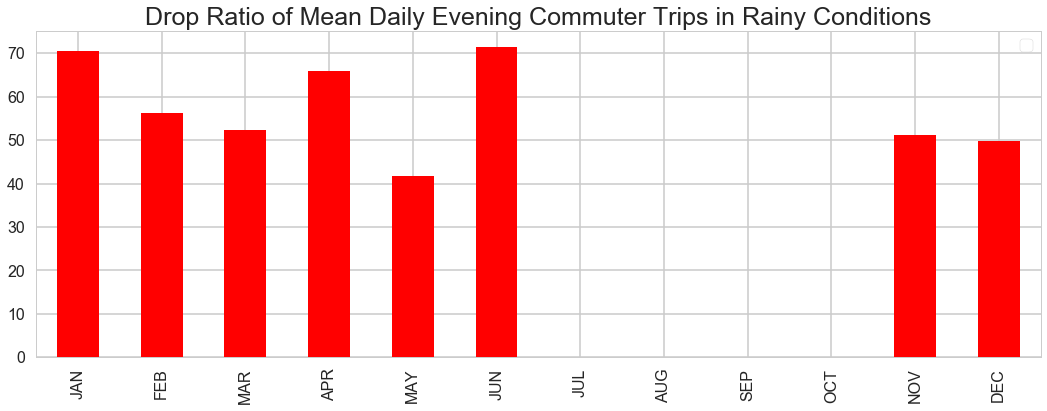

In [18]:
morning_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Rainy Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

evening_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Rainy Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()

# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

# Impact of Temperature on Commuter Trip Counts


<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Hot Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Hot Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

In [19]:
# Morning Commutes
m_COLD = morning_commutes[morning_commutes['temp_cat'] == 'Cold']
m_COLD = m_COLD.groupby(m_COLD.start_date.dt.date)['trip_id'].count()

m_NORM = morning_commutes[morning_commutes['temp_cat'] == 'Normal']
m_NORM = m_NORM.groupby(m_NORM.start_date.dt.date)['trip_id'].count()

m_HOT = morning_commutes[morning_commutes['temp_cat'] == 'Hot']
m_HOT = m_HOT.groupby(m_HOT.start_date.dt.date)['trip_id'].count()

In [20]:
chunks = []

for month in sorted(morning_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commutes[morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    m_HOT = month_data[month_data['temp_cat'] == 'Hot']
    m_HOT = m_HOT.groupby([m_HOT.start_date.dt.date])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(m_NORMAL, m_HOT, a_label='Normal', b_label='Hot')
    chunks.append(R)
    print('-' * 60)


Month of JAN
Normal Intervals   41
Hot Intervals   0
Normal mean        86.26829
Hot mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
Normal Intervals   51
Hot Intervals   5
Normal mean        111.23529
Hot mean        44.20000
Diff of Means 67.03529
Share Drop    60.26441
   z stat     2.26992
   p value    0.02321
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
Normal Intervals   64
Hot Intervals   0
Normal mean        115.42188
Hot mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of APR


/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


Normal Intervals   61
Hot Intervals   6
Normal mean        124.39344
Hot mean        92.66667
Diff of Means 31.72678
Share Drop    25.50518
   z stat     0.99910
   p value    0.31775
Can not reject the null Hypothesis
------------------------------------------------------------

Month of MAY
Normal Intervals   63
Hot Intervals   8
Normal mean        131.71429
Hot mean        91.87500
Diff of Means 39.83929
Share Drop    30.24675
   z stat     2.39130
   p value    0.01679
Reject the null Hypothesis
------------------------------------------------------------

Month of JUN
Normal Intervals   64
Hot Intervals   11
Normal mean        141.10938
Hot mean        53.72727
Diff of Means 87.38210
Share Drop    61.92509
   z stat     4.50031
   p value    0.00001
Reject the null Hypothesis
------------------------------------------------------------

Month of JUL
Normal Intervals   58
Hot Intervals   31
Normal mean        112.46552
Hot mean        87.29032
Diff of Means 25.17519
Share Drop    2

In [21]:
morning_hot_commute_t_test = pd.DataFrame(chunks)
morning_hot_commute_t_test['month'] = month_labels
morning_hot_commute_t_test.fillna(0, inplace=True)
morning_hot_commute_t_test

,Hot intervals,Hot mean,Normal intervals,Normal mean,can_reject,diff_of_means,drop_share,p_value,z_score,month
0,0,0.000000,41,86.268293,False,0.000000,0.000000,0.000000,0.000000,JAN
1,5,44.200000,51,111.235294,True,67.035294,60.264410,0.023213,2.269918,FEB
2,0,0.000000,64,115.421875,False,0.000000,0.000000,0.000000,0.000000,MAR
3,6,92.666667,61,124.393443,False,31.726776,25.505184,0.317748,0.999096,APR
4,8,91.875000,63,131.714286,True,39.839286,30.246746,0.016789,2.391304,MAY
5,11,53.727273,64,141.109375,True,87.382102,61.925086,0.000007,4.500305,JUN
6,31,87.290323,58,112.465517,True,25.175195,22.384812,0.043003,2.023683,JUL
7,32,114.656250,50,123.480000,False,8.823750,7.145894,0.276409,1.088421,AUG
8,49,74.836735,44,86.727273,False,11.890538,13.710264,0.291792,1.054200,SEP
9,35,91.457143,50,105.320000,False,13.862857,13.162606,0.310828,1.013487,OCT


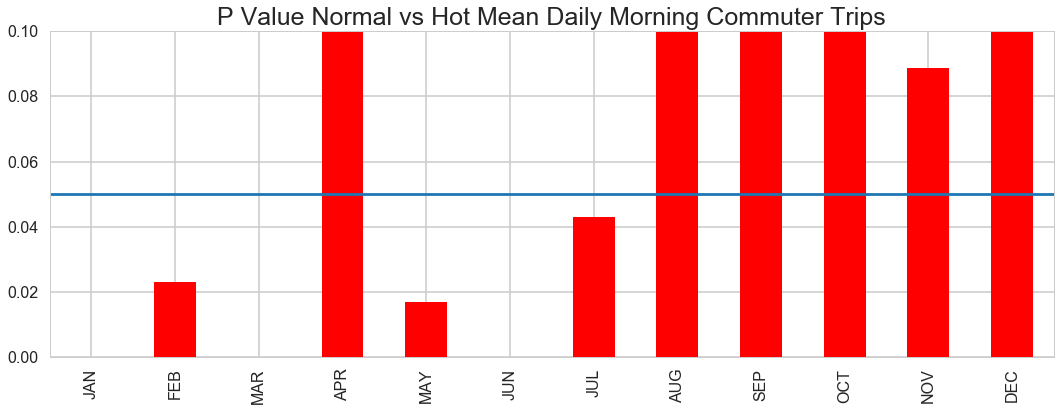

In [22]:
morning_hot_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'P Value Normal vs Hot Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

In [23]:
chunks = []

for month in sorted(morning_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commutes[morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    m_COLD = month_data[month_data['temp_cat'] == 'Cold']
    m_COLD = m_COLD.groupby([m_COLD.start_date.dt.date])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(m_NORMAL, m_COLD, a_label='Normal', b_label='Cold')
    chunks.append(R)
    print('-' * 60)


Month of JAN
Normal Intervals   41
Cold Intervals   45
Normal mean        86.26829
Cold mean        86.46667
Diff of Means -0.19837
Share Drop    -0.22995
   z stat     -0.06917
   p value    0.94485
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
Normal Intervals   51
Cold Intervals   23
Normal mean        111.23529
Cold mean        70.13043
Diff of Means 41.10486
Share Drop    36.95307
   z stat     3.27016
   p value    0.00107
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
Normal Intervals   64
Cold Intervals   15
Normal mean        115.42188
Cold mean        80.66667
Diff of Means 34.75521
Share Drop    30.11146
   z stat     2.18750
   p value    0.02871
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
Normal Intervals   61
Cold Intervals   17
Normal mean        124.39344
Cold mean        49.88235
Diff of Means 

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


Normal Intervals   50
Cold Intervals   0
Normal mean        123.48000
Cold mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
Normal Intervals   44
Cold Intervals   0
Normal mean        86.72727
Cold mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of OCT
Normal Intervals   50
Cold Intervals   5
Normal mean        105.32000
Cold mean        72.40000
Diff of Means 32.92000
Share Drop    31.25712
   z stat     1.41993
   p value    0.15563
Can not reject the null Hypothesis
------------------------------------------------------------

Month of NOV
Normal Intervals   57
Cold Intervals   22
Normal mean        105.00000
Cold mean        57.36364
Diff of Means 47.63636
Share Drop    45.36797
   z stat     3.

In [24]:
morning_cold_commute_t_test = pd.DataFrame(chunks)
morning_cold_commute_t_test['month'] = month_labels
morning_cold_commute_t_test.fillna(0, inplace=True)
morning_cold_commute_t_test

,Cold intervals,Cold mean,Normal intervals,Normal mean,can_reject,diff_of_means,drop_share,p_value,z_score,month
0,45,86.466667,41,86.268293,False,-0.198374,-0.229950,9.448537e-01,-0.069171,JAN
1,23,70.130435,51,111.235294,True,41.104859,36.953073,1.074866e-03,3.270160,FEB
2,15,80.666667,64,115.421875,True,34.755208,30.111457,2.870604e-02,2.187500,MAR
3,17,49.882353,61,124.393443,True,74.511090,59.899532,8.398991e-07,4.925860,APR
4,2,2.500000,63,131.714286,True,129.214286,98.101952,2.380772e-02,2.260218,MAY
5,0,0.000000,64,141.109375,False,0.000000,0.000000,0.000000e+00,0.000000,JUN
6,0,0.000000,58,112.465517,False,0.000000,0.000000,0.000000e+00,0.000000,JUL
7,0,0.000000,50,123.480000,False,0.000000,0.000000,0.000000e+00,0.000000,AUG
8,0,0.000000,44,86.727273,False,0.000000,0.000000,0.000000e+00,0.000000,SEP
9,5,72.400000,50,105.320000,False,32.920000,31.257121,1.556267e-01,1.419935,OCT


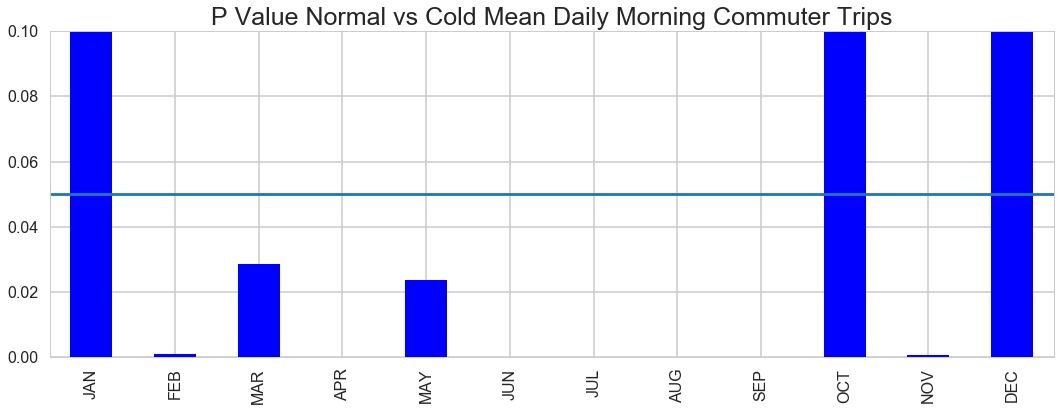

In [25]:
morning_cold_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'P Value Normal vs Cold Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

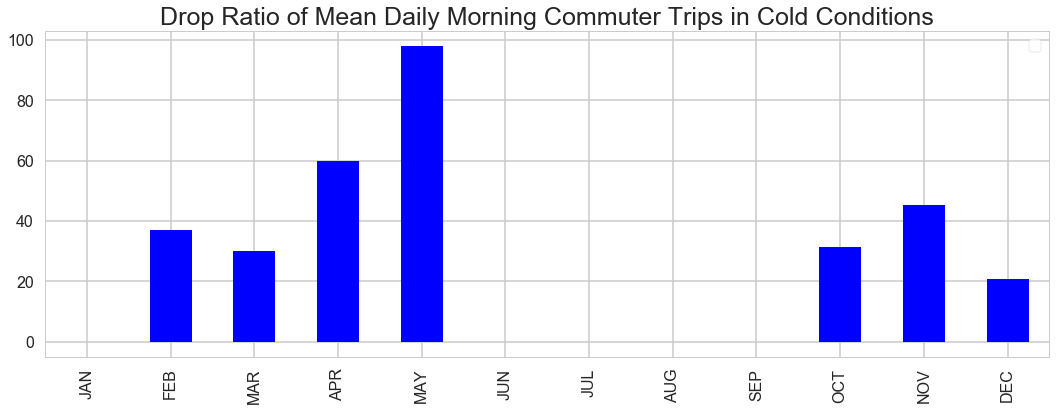

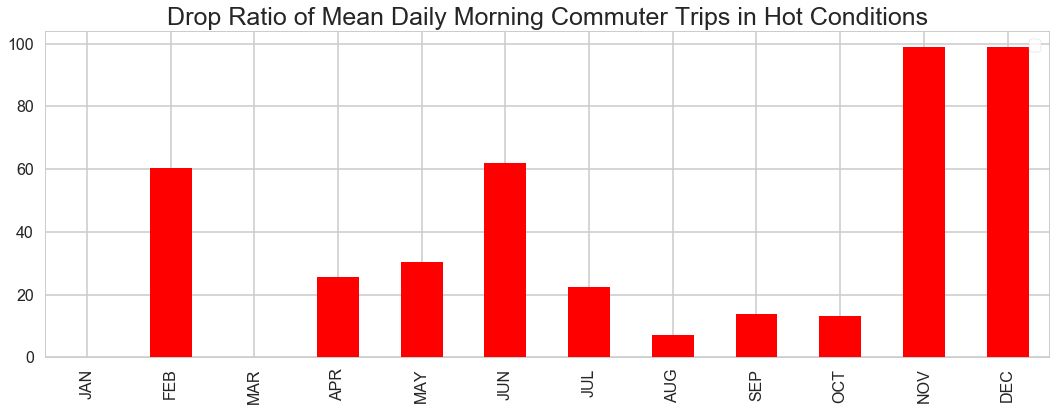

In [26]:
morning_cold_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

morning_hot_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)


<div class="alert alert-info">

<p><b>2b. Evening Commutes</b></p>


<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>


<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Cold Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Cold Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Hot Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Hot Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

In [27]:
# Evening Commutes
e_COLD = evening_commutes[evening_commutes['temp_cat'] == 'Cold']
e_COLD = e_COLD.groupby(e_COLD.start_date.dt.date)['trip_id'].count()

e_NORM = evening_commutes[evening_commutes['temp_cat'] == 'Normal']
e_NORM = e_NORM.groupby(e_NORM.start_date.dt.date)['trip_id'].count()

e_HOT = evening_commutes[evening_commutes['temp_cat'] == 'Hot']
e_HOT = e_HOT.groupby(e_HOT.start_date.dt.date)['trip_id'].count()

In [28]:
chunks = []

for month in sorted(evening_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = evening_commutes[evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    e_HOT = month_data[month_data['temp_cat'] == 'Hot']
    e_HOT = e_HOT.groupby([e_HOT.start_date.dt.date])['trip_id'].count()

    e_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    e_NORMAL = e_NORMAL.groupby([e_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(e_NORMAL, e_HOT, a_label='Normal', b_label='Hot')
    chunks.append(R)
    print('-' * 60)


Month of JAN
Normal Intervals   40
Hot Intervals   0
Normal mean        91.50000
Hot mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
Normal Intervals   48
Hot Intervals   5
Normal mean        106.02083
Hot mean        58.80000
Diff of Means 47.22083
Share Drop    44.53920
   z stat     1.67360
   p value    0.09421
Can not reject the null Hypothesis
------------------------------------------------------------

Month of MAR


/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


Normal Intervals   59
Hot Intervals   9
Normal mean        122.55932
Hot mean        54.11111
Diff of Means 68.44821
Share Drop    55.84905
   z stat     3.07658
   p value    0.00209
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
Normal Intervals   53
Hot Intervals   10
Normal mean        117.84906
Hot mean        127.60000
Diff of Means -9.75094
Share Drop    -8.27410
   z stat     -0.60188
   p value    0.54725
Can not reject the null Hypothesis
------------------------------------------------------------

Month of MAY
Normal Intervals   60
Hot Intervals   11
Normal mean        121.78333
Hot mean        88.09091
Diff of Means 33.69242
Share Drop    27.66587
   z stat     2.05789
   p value    0.03960
Reject the null Hypothesis
------------------------------------------------------------

Month of JUN
Normal Intervals   63
Hot Intervals   17
Normal mean        132.46032
Hot mean        79.82353
Diff of Means 52.63679
Share Drop  

In [29]:
evening_hot_commute_t_test = pd.DataFrame(chunks)
evening_hot_commute_t_test['month'] = month_labels
evening_hot_commute_t_test.fillna(0, inplace=True)
evening_hot_commute_t_test

,Hot intervals,Hot mean,Normal intervals,Normal mean,can_reject,diff_of_means,drop_share,p_value,z_score,month
0,0,0.000000,40,91.500000,False,0.000000,0.000000,0.000000,0.000000,JAN
1,5,58.800000,48,106.020833,False,47.220833,44.539202,0.094210,1.673597,FEB
2,9,54.111111,59,122.559322,True,68.448211,55.849045,0.002094,3.076577,MAR
3,10,127.600000,53,117.849057,False,-9.750943,-8.274095,0.547251,-0.601884,APR
4,11,88.090909,60,121.783333,True,33.692424,27.665875,0.039601,2.057890,MAY
5,17,79.823529,63,132.460317,True,52.636788,39.737779,0.000499,3.481329,JUN
6,20,78.750000,62,124.322581,True,45.572581,36.656720,0.003806,2.893847,JUL
7,21,72.857143,61,139.754098,True,66.896956,47.867616,0.000058,4.021082,AUG
8,34,87.794118,51,92.392157,False,4.598039,4.976655,0.673307,0.421614,SEP
9,31,87.000000,52,108.711538,False,21.711538,19.971696,0.084088,1.727446,OCT


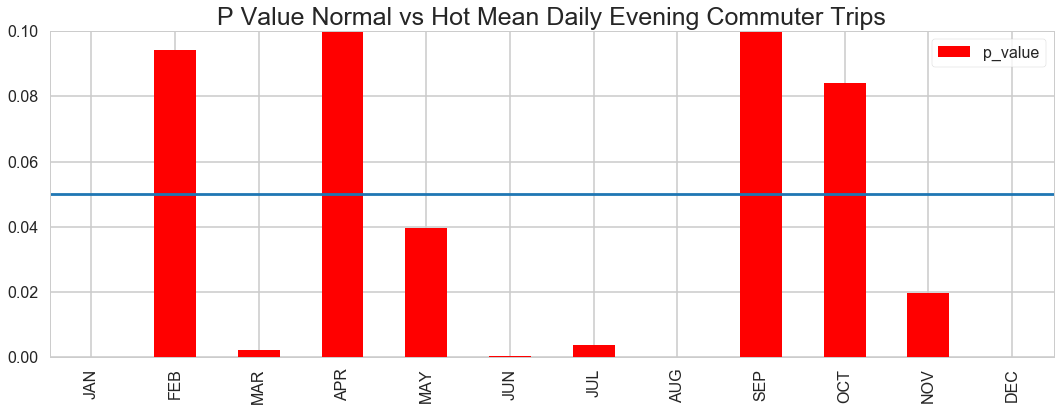

In [30]:
evening_hot_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim(0, 0.1)
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'P Value Normal vs Hot Mean Daily Evening Commuter Trips'
plt.legend(loc=1, frameon=True)
plt.title(title, size=TITLE_FONT_SIZE)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

In [31]:
chunks = []

for month in sorted(evening_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = evening_commutes[evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    e_COLD = month_data[month_data['temp_cat'] == 'Cold']
    e_COLD = e_COLD.groupby([e_COLD.start_date.dt.date])['trip_id'].count()

    e_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    e_NORMAL = e_NORMAL.groupby([e_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(e_NORMAL, e_COLD, a_label='Normal', b_label='Cold')
    chunks.append(R)
    print('-' * 60)


Month of JAN
Normal Intervals   40
Cold Intervals   49
Normal mean        91.50000
Cold mean        79.75510
Diff of Means 11.74490
Share Drop    12.83595
   z stat     0.84953
   p value    0.39559
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
Normal Intervals   48
Cold Intervals   31
Normal mean        106.02083
Cold mean        61.67742
Diff of Means 44.34341
Share Drop    41.82519
   z stat     3.54421
   p value    0.00039
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
Normal Intervals   59
Cold Intervals   18
Normal mean        122.55932
Cold mean        58.05556
Diff of Means 64.50377
Share Drop    52.63065
   z stat     4.11630
   p value    0.00004
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
Normal Intervals   53
Cold Intervals   19
Normal mean        117.84906
Cold mean        70.00000
Diff of Means 4

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


Normal Intervals   62
Cold Intervals   0
Normal mean        124.32258
Cold mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of AUG
Normal Intervals   61
Cold Intervals   1
Normal mean        139.75410
Cold mean        1.00000
Diff of Means 138.75410
Share Drop    99.28446
   z stat     1.70434
   p value    0.08832
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
Normal Intervals   51
Cold Intervals   0
Normal mean        92.39216
Cold mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of OCT
Normal Intervals   52
Cold Intervals   8
Normal mean        108.71154
Cold mean        65.50000
Diff of Means 43.21154
Share Drop    39.74881
   z stat     2.1

In [32]:
evening_cold_commute_t_test = pd.DataFrame(chunks)
evening_cold_commute_t_test['month'] = month_labels
evening_cold_commute_t_test.fillna(0, inplace=True)
evening_cold_commute_t_test

,Cold intervals,Cold mean,Normal intervals,Normal mean,can_reject,diff_of_means,drop_share,p_value,z_score,month
0,49,79.755102,40,91.500000,False,11.744898,12.835954,0.395587,0.849530,JAN
1,31,61.677419,48,106.020833,True,44.343414,41.825189,0.000394,3.544205,FEB
2,18,58.055556,59,122.559322,True,64.503766,52.630649,0.000039,4.116301,MAR
3,19,70.000000,53,117.849057,True,47.849057,40.601985,0.000498,3.481617,APR
4,14,45.285714,60,121.783333,True,76.497619,62.814522,0.000086,3.926473,MAY
5,3,28.000000,63,132.460317,True,104.460317,78.861594,0.009714,2.585840,JUN
6,0,0.000000,62,124.322581,False,0.000000,0.000000,0.000000,0.000000,JUL
7,1,1.000000,61,139.754098,False,138.754098,99.284457,0.088318,1.704336,AUG
8,0,0.000000,51,92.392157,False,0.000000,0.000000,0.000000,0.000000,SEP
9,8,65.500000,52,108.711538,True,43.211538,39.748806,0.032195,2.141979,OCT


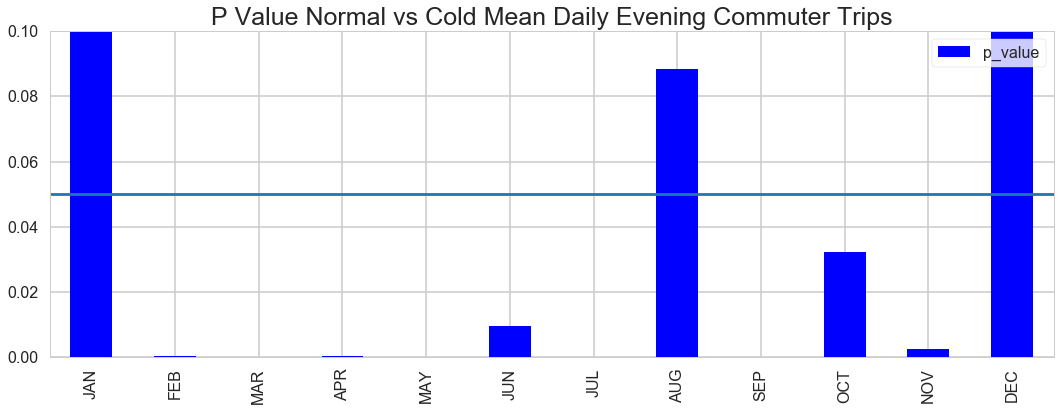

In [33]:
evening_cold_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'P Value Normal vs Cold Mean Daily Evening Commuter Trips'
plt.legend(loc=1, frameon=True)
plt.title(title, size=TITLE_FONT_SIZE)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

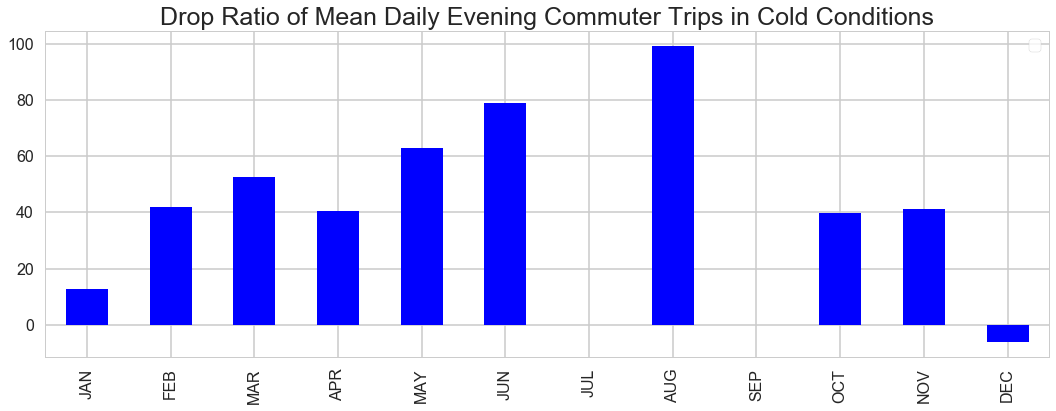

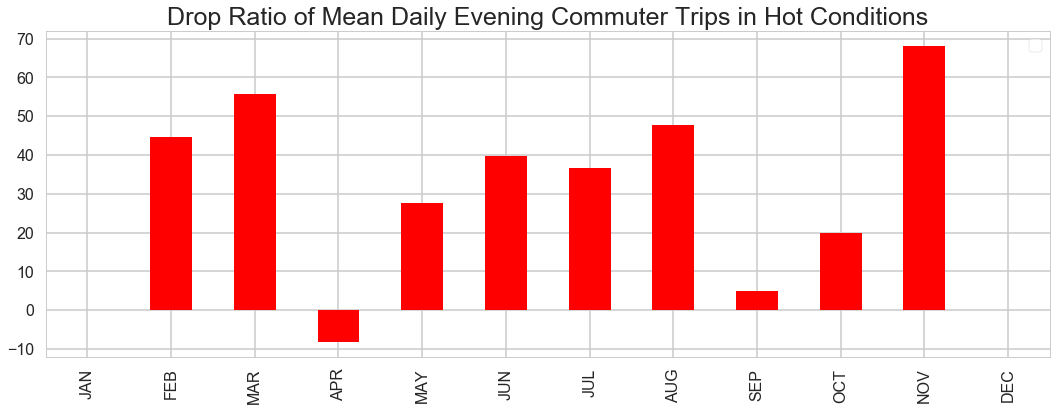

In [34]:
evening_cold_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

evening_hot_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)